## Reference

* 데이터 증강:
  * terryum 님의 웨어러블 센서 데이터 증강 기법 - https://github.com/terryum/Data-Augmentation-For-Wearable-Sensor-Data 

* 모델구현
  * https://machinelearningmastery.com/how-to-develop-rnn-models-for-human-activity-recognition-time-series-classification/?utm_source=pocket_mylist
    1. LSTM 단독모델
    2. CNN-LSTM 결합모델
    3. ConvLSTM 모델
    비교 3가지 돌려봤는데 CNN-LSTM 이 가장 성능이 좋아서 선택
  * CNN단독 모델 보다 CNN-LSTM 모델이 우수한 이유 설명 - 미세먼지 예측 성능 개선을 위한 CNN-LSTM 결합 방법 http://koreascience.or.kr/article/JAKO202005653789386.page
  * 그외 시계열 데이터 LSTM 응용 방법 - https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/ 

* 교차검증 및 성능 강화
  * early stopping 과 callback 을 사용하여 과적합을 방지할 수 있다. - https://tykimos.github.io/2017/07/09/Early_Stopping/ 
  * 앙상블 기법
    * softvoting
    * stacking - https://machinelearningmastery.com/stacking-ensemble-for-deep-learning-neural-networks/

In [1]:
# 구글 드라이브 마운트
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# 기본 directory 설정
import os
os.chdir('/content/drive/MyDrive/Monthly_Workout')

In [3]:
# 모듈 불러오기
import random
import pandas as pd
import numpy as np
from tqdm import tqdm
from math import pi
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline

In [4]:
# 데이터 불러오기
path = './' # 기본 directory 경로에 추가 할 경로

train = pd.read_csv(path + 'train_features.csv')
train_labels = pd.read_csv(path + 'train_labels.csv')
test = pd.read_csv(path + 'test_features.csv')
submission = pd.read_csv(path + 'sample_submission.csv')

In [5]:
train

,id,time,acc_x,acc_y,acc_z,gy_x,gy_y,gy_z
0,0,0,1.206087,-0.179371,-0.148447,-0.591608,-30.549010,-31.676112
1,0,1,1.287696,-0.198974,-0.182444,0.303100,-39.139103,-24.927216
2,0,2,1.304609,-0.195114,-0.253382,-3.617278,-44.122565,-25.019629
3,0,3,1.293095,-0.230366,-0.215210,2.712986,-53.597843,-27.454013
4,0,4,1.300887,-0.187757,-0.222523,4.286707,-57.906561,-27.961234
...,...,...,...,...,...,...,...,...
1874995,3124,595,-0.712530,-0.658357,0.293707,-29.367857,-104.013664,-76.290437
1874996,3124,596,-0.683037,-0.658466,0.329223,-30.149089,-101.796809,-76.625087
1874997,3124,597,-0.664730,-0.666625,0.364114,-27.873095,-98.776072,-79.365125
1874998,3124,598,-0.630534,-0.682565,0.373696,-23.636550,-99.139495,-80.259478


In [6]:
train_labels

,id,label,label_desc
0,0,37,Shoulder Press (dumbbell)
1,1,26,Non-Exercise
2,2,3,Biceps Curl (band)
3,3,26,Non-Exercise
4,4,26,Non-Exercise
...,...,...,...
3120,3120,26,Non-Exercise
3121,3121,26,Non-Exercise
3122,3122,15,Dynamic Stretch (at your own pace)
3123,3123,26,Non-Exercise


In [7]:
act_list=train.iloc[:,2:].columns
acc_list=['acc_x','acc_y','acc_z']
gy_list=['gy_x','gy_y','gy_z']
act_list

Index(['acc_x', 'acc_y', 'acc_z', 'gy_x', 'gy_y', 'gy_z'], dtype='object')

In [8]:
# acc 데이터와 gy 데이터로 분할
def sensor_split(data):
    X_acc = []
    X_gy = []

    for i in tqdm(data['id'].unique()):
        temp_acc = np.array(data[data['id'] == i].loc[:,acc_list])
        temp_gy = np.array(data[data['id'] == i].loc[:,gy_list])
        X_acc.append(temp_acc)
        X_gy.append(temp_gy)
      
    X_acc = np.array(X_acc).reshape(-1,600,3)
    X_gy = np.array(X_gy).reshape(-1,600,3)

    return X_acc, X_gy

In [9]:
# 데이터 증강
def aug(data, uid, shift):
    shift_data = np.roll(data[uid], shift, axis=0)
    return shift_data
def rolling(data):
  aug_data=[]
  for i in range(data.shape[0]):
    temp=list((aug(data,i,int(random.random()*600))))
    aug_data.append(temp)
  return np.array(aug_data)

sigma = 0.2
knot = 4
def GenerateRandomCurves(X, sigma, knot=4):
    xx = (np.ones((X.shape[1],1))*(np.arange(0,X.shape[0], (X.shape[0]-1)/(knot+1)))).transpose()
    yy = np.random.normal(loc=1.0, scale=sigma, size=(knot+2, X.shape[1]))
    x_range = np.arange(X.shape[0])
    cs_x = CubicSpline(xx[:,0], yy[:,0])
    cs_y = CubicSpline(xx[:,1], yy[:,1])
    cs_z = CubicSpline(xx[:,2], yy[:,2])
    return np.array([cs_x(x_range),cs_y(x_range),cs_z(x_range)]).transpose()

# Time Warping
sigma = 0.2
knot = 4
def DistortTimesteps(X, sigma):
    tt = GenerateRandomCurves(X, sigma) # Regard these samples aroun 1 as time intervals
    tt_cum = np.cumsum(tt, axis=0)        # Add intervals to make a cumulative graph
    # Make the last value to have X.shape[0]
    t_scale = [(X.shape[0]-1)/tt_cum[-1,0],(X.shape[0]-1)/tt_cum[-1,1],(X.shape[0]-1)/tt_cum[-1,2]]
    tt_cum[:,0] = tt_cum[:,0]*t_scale[0]
    tt_cum[:,1] = tt_cum[:,1]*t_scale[1]
    tt_cum[:,2] = tt_cum[:,2]*t_scale[2]
    return tt_cum

def TimeWarp(X, sigma):
    tt_new = DistortTimesteps(X, sigma)
    X_new = np.zeros(X.shape)
    x_range = np.arange(X.shape[0])
    X_new[:,0] = np.interp(x_range, tt_new[:,0], X[:,0])
    X_new[:,1] = np.interp(x_range, tt_new[:,1], X[:,1])
    X_new[:,2] = np.interp(x_range, tt_new[:,2], X[:,2])
    return X_new

def ts(data, method,sigma):
    new_data=[]
    for i in range(data.shape[0]):
        temp=list(method(data[i], sigma))
        new_data.append(temp)
    return np.array(new_data)

In [10]:
# 데이터 증강 (반복하고 싶은 만큼 조정)
def start_augmentation(train, train_labels):
    # acc, gy 데이터 분할
    X_train_mod=pd.merge(train,train_labels,how='left',on='id')
    X_train_acc, X_train_gy= sensor_split(X_train_mod)

    # 증강시키고 추가할 임시 데이터 복사본
    X_train_acc_temp = X_train_acc.copy()
    X_train_gy_temp = X_train_gy.copy()

    # label 데이터 변환
    y_train = train_labels['label']
    y_train_total = np.append(y_train, y_train, axis=0)

    rep = 4 # 5이상의 경우 reshape 과정에서 reset될 가능성 높음
    for i in range(rep):
        X_train_acc_roll = rolling(X_train_acc_temp) # Rolling 만
        X_train_acc_rt = ts(rolling(X_train_acc_temp), TimeWarp, 0.2) # 롤링한 데이터에 Time Warping

        X_train_gy_roll = rolling(X_train_gy_temp)
        X_train_gy_rt = ts(rolling(X_train_gy_temp), TimeWarp, 0.2)

        # 증강시킨 데이터 원래 데이터에 추가
        X_train_acc = np.append(X_train_acc, X_train_acc_roll, axis=0)
        X_train_acc = np.append(X_train_acc, X_train_acc_rt, axis=0)
        X_train_gy = np.append(X_train_gy, X_train_gy_roll, axis=0)
        X_train_gy = np.append(X_train_gy, X_train_gy_rt, axis=0)

        y_train_total = np.append(y_train_total, y_train, axis=0) # label 데이터 복제
        if i != (rep-1): # 마지막 한 번 제외
            y_train_total = np.append(y_train_total, y_train, axis=0)

    return X_train_acc, X_train_gy, y_train_total 

In [11]:
X_train_acc, X_train_gy, y_train_total = start_augmentation(train, train_labels)

print(X_train_acc.shape, X_train_gy.shape, y_train_total.shape)

100%|██████████| 3125/3125 [00:15<00:00, 204.36it/s]


(28125, 600, 3) (28125, 600, 3) (28125,)


In [12]:
# train 데이터만 Grdient (배열 형태로 있기 때문에 진행하고 나중에 합치기)
grad_acc = np.gradient(X_train_acc, axis=0)
grad_gy = np.gradient(X_train_gy, axis=0)

grad_acc.shape, grad_gy.shape

((28125, 600, 3), (28125, 600, 3))

In [13]:
# test 데이터만 Gradient
feature_names = ['acc_x','acc_y','acc_z','gy_x','gy_y','gy_z']

grad_cols=[]
for col in feature_names:
    grad_cols.append(f"grad_{col}")

total_feature_names = feature_names + grad_cols

for uid in tqdm(test['id'].unique()):
    temp = test.loc[test['id']==uid, feature_names]
    grad = np.gradient(temp, axis=0)
    test.loc[test['id']==uid, grad_cols] = grad
    
test

100%|██████████| 782/782 [00:10<00:00, 74.22it/s]


,id,time,acc_x,acc_y,acc_z,gy_x,gy_y,gy_z,grad_acc_x,grad_acc_y,grad_acc_z,grad_gy_x,grad_gy_y,grad_gy_z
0,3125,0,-0.628100,-0.160155,0.151487,49.665357,88.435961,13.597668,0.165552,0.172617,-0.205212,7.287703,7.749380,2.680790
1,3125,1,-0.462548,0.012462,-0.053726,56.953059,96.185341,16.278458,0.132309,0.034183,-0.140745,-10.053980,2.700246,-0.134312
2,3125,2,-0.363481,-0.091789,-0.130004,29.557396,93.836453,13.329043,0.055399,-0.126166,-0.069664,-16.633444,-3.788310,-1.414343
3,3125,3,-0.351750,-0.239870,-0.193053,23.686172,88.608721,13.449771,0.025274,-0.015987,-0.094309,-4.573663,-4.254373,0.277935
4,3125,4,-0.312934,-0.123762,-0.318621,20.410071,85.327707,13.884912,0.038152,0.141825,-0.113757,-7.742728,-9.060490,-1.380580
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
469195,3906,595,0.104191,-0.784979,0.639513,-10.475346,14.095361,-190.358982,-0.034067,0.048820,-0.011846,-15.157454,-19.804465,4.896134
469196,3906,596,0.103297,-0.758954,0.615687,-25.360272,-8.523018,-180.393291,0.012051,0.017795,-0.026665,-8.721189,-18.640803,13.867411
469197,3906,597,0.128294,-0.749389,0.586184,-27.917723,-23.186245,-162.624160,0.000417,0.033111,-0.021145,-1.243854,-10.942268,20.815807
469198,3906,598,0.104130,-0.692731,0.573397,-27.847980,-30.407555,-138.761676,-0.034497,0.067951,-0.014702,-0.991501,-6.699987,23.100175


In [14]:
# np array 형태를 dataframe 으로 변환
def np_to_df(X_train_acc, X_train_gy):
    acc = [e for sl in X_train_acc for e in sl]
    gy = [e for sl in X_train_gy for e in sl]
    acc_grad = [e for sl in grad_acc for e in sl]
    gy_grad = [e for sl in grad_gy for e in sl]

    df_report_acc = np.stack(acc, axis = 0)
    df_report_gy = np.stack(gy, axis = 0)
    df_report_acc_grad = np.stack(acc_grad, axis = 0)
    df_report_gy_grad = np.stack(gy_grad, axis = 0)

    df_acc = pd.DataFrame(df_report_acc, columns= ['acc_x', 'acc_y', 'acc_z']) 
    df_gy = pd.DataFrame(df_report_gy, columns= ['gy_x', 'gy_y', 'gy_z']) 
    df_acc_grad = pd.DataFrame(df_report_acc_grad, columns= ['grad_acc_x', 'grad_acc_y', 'grad_acc_z']) 
    df_gy_grad = pd.DataFrame(df_report_gy_grad, columns= ['grad_gy_x', 'grad_gy_y', 'grad_gy_z']) 

    # acc, gy 데이터프레임 병합
    df_aug_result = pd.concat([df_acc, df_gy, df_acc_grad, df_gy_grad], axis = 1)
    
    return df_aug_result

In [15]:
train = np_to_df(X_train_acc, X_train_gy)
train

,acc_x,acc_y,acc_z,gy_x,gy_y,gy_z,grad_acc_x,grad_acc_y,grad_acc_z,grad_gy_x,grad_gy_y,grad_gy_z
0,1.206087,-0.179371,-0.148447,-0.591608,-30.549010,-31.676112,-1.417881,0.100612,1.003073,18.823551,40.760173,39.066459
1,1.287696,-0.198974,-0.182444,0.303100,-39.139103,-24.927216,-1.544660,0.180419,0.984615,26.221163,40.119956,32.874474
2,1.304609,-0.195114,-0.253382,-3.617278,-44.122565,-25.019629,-1.561614,0.193701,1.059415,21.186667,40.169365,27.002177
3,1.293095,-0.230366,-0.215210,2.712986,-53.597843,-27.454013,-1.482737,0.189084,1.043147,6.463619,42.818780,27.161168
4,1.300887,-0.187757,-0.222523,4.286707,-57.906561,-27.961234,-1.463457,0.096684,1.083614,3.953957,49.807351,24.740778
...,...,...,...,...,...,...,...,...,...,...,...,...
16874995,-0.971230,-0.288130,-0.126173,1.833365,-67.901831,-44.842938,-0.689662,-1.146424,0.008920,-55.273485,-82.885609,-105.643756
16874996,-0.995573,-0.284811,-0.170667,-27.164274,-69.478935,-44.594249,-0.633142,-1.130261,-0.023029,-84.673621,-101.498503,-102.565668
16874997,-0.983249,-0.288758,-0.185369,-32.662722,-71.612429,-43.720907,-0.554016,-1.124736,-0.059324,-74.006497,-112.917404,-99.323642
16874998,-0.953504,-0.293454,-0.186189,-19.418694,-73.223859,-46.209606,-0.469659,-1.124485,-0.107695,-46.024551,-118.473430,-91.710253


In [16]:
# 시각화를 위해서 id 로 묶어주기 위해 잠시 생성
val_id = []
n = int(len(train))

# 600번씩 반복되도록 임의로 배열 생성
for i in range(n//600):
    for j in range(600):
        val_id.append(i)

train.insert(0, 'id', val_id) # 리스트값 id 열에 붙여넣기
train.head(603)

,id,acc_x,acc_y,acc_z,gy_x,gy_y,gy_z,grad_acc_x,grad_acc_y,grad_acc_z,grad_gy_x,grad_gy_y,grad_gy_z
0,0,1.206087,-0.179371,-0.148447,-0.591608,-30.549010,-31.676112,-1.417881,0.100612,1.003073,18.823551,40.760173,39.066459
1,0,1.287696,-0.198974,-0.182444,0.303100,-39.139103,-24.927216,-1.544660,0.180419,0.984615,26.221163,40.119956,32.874474
2,0,1.304609,-0.195114,-0.253382,-3.617278,-44.122565,-25.019629,-1.561614,0.193701,1.059415,21.186667,40.169365,27.002177
3,0,1.293095,-0.230366,-0.215210,2.712986,-53.597843,-27.454013,-1.482737,0.189084,1.043147,6.463619,42.818780,27.161168
4,0,1.300887,-0.187757,-0.222523,4.286707,-57.906561,-27.961234,-1.463457,0.096684,1.083614,3.953957,49.807351,24.740778
...,...,...,...,...,...,...,...,...,...,...,...,...,...
598,0,1.031553,-0.387862,-0.277857,-9.710746,28.697694,20.631577,-1.216848,-0.004274,1.103091,91.899528,-88.568222,-37.648995
599,0,1.138159,-0.426846,-0.430263,-15.891015,21.675950,32.123007,-1.117311,0.270063,1.313362,94.579702,-85.886923,-52.030343
600,1,-0.211795,-0.078760,0.854627,18.231943,10.211164,7.390348,-0.482349,-0.129252,0.472822,-6.743979,-79.533633,4.579488
601,1,-0.256963,-0.018555,0.802172,26.524263,0.980852,7.947258,-0.521364,-0.046137,0.497249,10.167773,-70.606056,3.020300


### 증강시킨 데이터 비교해보기
1. 원래 id 2 번째의 데이터 - Bicepcurl (Band)
2. id 2 의 데이터를 Rolling 한 데이터
3. id 2 의 데이터를 Rolling -> Time Warping 한 데이터  

4. 원래 id 3124 번째의 데이터 - Bicepcurl
5. id 3124 의 데이터를 Rolling 한 데이터
6. id 3124 의 데이터를 Rolling -> Time Warping 한 데이터  

같은 동작인데 밴드의 유무 차이?  
심지어 그래프 파형도 비슷하다!  
그럼 어떻게 구별할까??  
어렵다 어려워..

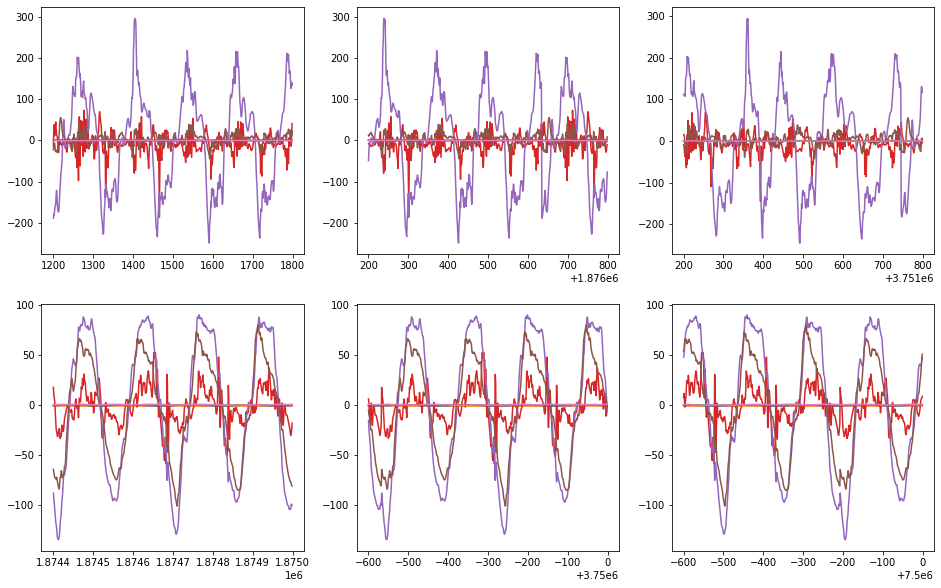

In [17]:
n_id = [0, 1, 2] # 원하는 id 별 증강 데이터 확인 (0의 경우 0 번째 데이터)
fig,ax=plt.subplots(nrows=2,ncols=3, figsize=(16, 10))
ex1=train[train['id']==n_id[2]].iloc[:,1:8] #id==0 데이터
ex2=train[train['id']==n_id[2]+3125].iloc[:,1:8] # id==0 증강 데이터
ex3=train[train['id']==n_id[2]+6250].iloc[:,1:8]
ex4=train[train['id']==n_id[0]+3124].iloc[:,1:8]
ex5=train[train['id']==n_id[0]+6249].iloc[:,1:8]
ex6=train[train['id']==n_id[0]+12499].iloc[:,1:8]

ax[0,0].plot(ex1)
ax[0,1].plot(ex2)
ax[0,2].plot(ex3)
ax[1,0].plot(ex4)
ax[1,1].plot(ex5)
ax[1,2].plot(ex6)

In [18]:
train.head(603)

,id,acc_x,acc_y,acc_z,gy_x,gy_y,gy_z,grad_acc_x,grad_acc_y,grad_acc_z,grad_gy_x,grad_gy_y,grad_gy_z
0,0,1.206087,-0.179371,-0.148447,-0.591608,-30.549010,-31.676112,-1.417881,0.100612,1.003073,18.823551,40.760173,39.066459
1,0,1.287696,-0.198974,-0.182444,0.303100,-39.139103,-24.927216,-1.544660,0.180419,0.984615,26.221163,40.119956,32.874474
2,0,1.304609,-0.195114,-0.253382,-3.617278,-44.122565,-25.019629,-1.561614,0.193701,1.059415,21.186667,40.169365,27.002177
3,0,1.293095,-0.230366,-0.215210,2.712986,-53.597843,-27.454013,-1.482737,0.189084,1.043147,6.463619,42.818780,27.161168
4,0,1.300887,-0.187757,-0.222523,4.286707,-57.906561,-27.961234,-1.463457,0.096684,1.083614,3.953957,49.807351,24.740778
...,...,...,...,...,...,...,...,...,...,...,...,...,...
598,0,1.031553,-0.387862,-0.277857,-9.710746,28.697694,20.631577,-1.216848,-0.004274,1.103091,91.899528,-88.568222,-37.648995
599,0,1.138159,-0.426846,-0.430263,-15.891015,21.675950,32.123007,-1.117311,0.270063,1.313362,94.579702,-85.886923,-52.030343
600,1,-0.211795,-0.078760,0.854627,18.231943,10.211164,7.390348,-0.482349,-0.129252,0.472822,-6.743979,-79.533633,4.579488
601,1,-0.256963,-0.018555,0.802172,26.524263,0.980852,7.947258,-0.521364,-0.046137,0.497249,10.167773,-70.606056,3.020300


In [19]:
train.drop(['id'], axis=1, inplace=True) # id 의 활용은 끝났으니 제거

In [20]:
# 가속도
train['acc_t'] = (train['acc_x'] ** 2) + (train['acc_y'] ** 2) + (train['acc_z'] ** 2) ** (1/3)
test['acc_t'] = (test['acc_x'] ** 2) + (test['acc_y'] ** 2) + (test['acc_z'] ** 2) ** (1/3)

train['gy_t'] = (train['gy_x'] ** 2) + (train['gy_y'] ** 2) + (train['gy_z'] ** 2) ** (1/3)
test['gy_t'] = (test['gy_x'] ** 2) + (test['gy_y'] ** 2) + (test['gy_z'] ** 2) ** (1/3)

# Signal 극대화 (peak 캐치 유용)
train['acc_mag'] = (train['acc_x'] ** 2) + (train['acc_y'] ** 2) + (train['acc_z'] ** 2)
test['acc_mag'] = (test['acc_x'] ** 2) + (test['acc_y'] ** 2) + (test['acc_z'] ** 2)

train['gy_mag'] = (train['gy_x'] ** 2) + (train['gy_y'] ** 2) + (train['gy_z'] ** 2)
test['gy_mag'] = (test['gy_x'] ** 2) + (test['gy_y'] ** 2) + (test['gy_z'] ** 2)

In [21]:
# vector
train['acc_vec'] = np.sqrt((train['acc_x'] ** 2) +(train['acc_y'] ** 2)+(train['acc_z'] ** 2))
test['acc_vec'] = np.sqrt((test['acc_x'] ** 2) +(test['acc_y'] ** 2)+(test['acc_z'] ** 2))

train['gy_vec'] = np.sqrt((train['gy_x'] ** 2) +(train['gy_y'] ** 2)+(train['gy_z'] ** 2))
test['gy_vec'] = np.sqrt((test['gy_x'] ** 2) +(test['gy_y'] ** 2)+(test['gy_z'] ** 2))

# 자이로스코프 무게중심
train['gy_gravity'] = (train['gy_x']+train['gy_y']+train['gy_z'])/3
test['gy_gravity'] = (test['gy_x']+test['gy_y']+test['gy_z'])/3

In [22]:
# roll & pitch
train['roll'] = np.arctan(train['acc_y']/np.sqrt(train['acc_x'] ** 2 + train['acc_z'] ** 2))
test['roll'] = np.arctan(test['acc_y']/np.sqrt(test['acc_x'] ** 2 + test['acc_z'] ** 2))

train['pitch'] = np.arctan(train['acc_x']/np.sqrt(train['acc_y'] ** 2 + train['acc_z'] ** 2))
test['pitch'] = np.arctan(test['acc_x']/np.sqrt(test['acc_y'] ** 2 + test['acc_z'] ** 2))

train['math_roll'] = np.arctan(- train['acc_x']/np.sqrt(train['acc_y'] ** 2 + train['acc_z'] ** 2)) * (180/pi)
test['math_roll'] = np.arctan(- test['acc_x']/np.sqrt(test['acc_y'] ** 2 + test['acc_z'] ** 2)) * (180/pi)

train['math_pitch'] = np.arctan(train['acc_y']/np.sqrt(train['acc_x'] ** 2 + train['acc_z'] ** 2)) * (180/pi)
test['math_pitch'] = np.arctan(test['acc_y']/np.sqrt(test['acc_x'] ** 2 + test['acc_z'] ** 2)) * (180/pi)

train['gy_roll'] = np.arctan(train['gy_y']/np.sqrt(train['gy_x'] ** 2 + train['gy_z'] ** 2))
test['gy_roll'] = np.arctan(test['gy_y']/np.sqrt(test['gy_x'] ** 2 + test['gy_z'] ** 2))

train['gy_pitch'] = np.arctan(train['gy_x']/np.sqrt(train['gy_y'] ** 2 + train['gy_z'] ** 2))
test['gy_pitch'] = np.arctan(test['gy_x']/np.sqrt(test['gy_y'] ** 2 + test['gy_z'] ** 2))

train['gy_math_roll'] = np.arctan(- train['gy_x']/np.sqrt(train['gy_y'] ** 2 + train['gy_z'] ** 2)) * (180/pi)
test['gy_math_roll'] = np.arctan(- test['gy_x']/np.sqrt(test['gy_y'] ** 2 + test['gy_z'] ** 2)) * (180/pi)

train['gy_math_pitch'] = np.arctan(train['gy_y']/np.sqrt(train['gy_x'] ** 2 + train['gy_z'] ** 2)) * (180/pi)
test['gy_math_pitch'] = np.arctan(test['gy_y']/np.sqrt(test['gy_x'] ** 2 + test['gy_z'] ** 2)) * (180/pi)

print(train.shape)
train

(16875000, 27)


,acc_x,acc_y,acc_z,gy_x,gy_y,gy_z,grad_acc_x,grad_acc_y,grad_acc_z,grad_gy_x,grad_gy_y,grad_gy_z,acc_t,gy_t,acc_mag,gy_mag,acc_vec,gy_vec,gy_gravity,roll,pitch,math_roll,math_pitch,gy_roll,gy_pitch,gy_math_roll,gy_math_pitch
0,1.206087,-0.179371,-0.148447,-0.591608,-30.549010,-31.676112,-1.417881,0.100612,1.003073,18.823551,40.760173,39.066459,1.767177,943.603223,1.508855,1936.968046,1.228355,44.010999,-20.938910,-0.146550,1.380095,-79.073624,-8.396683,-0.767200,-0.013443,0.770209,-43.957305
1,1.287696,-0.198974,-0.182444,0.303100,-39.139103,-24.927216,-1.544660,0.180419,0.984615,26.221163,40.119956,32.874474,2.019429,1540.494535,1.731038,2153.327355,1.315689,46.403958,-21.254406,-0.151814,1.364146,-78.159835,-8.698302,-1.003661,0.006532,-0.374246,-57.505519
2,1.304609,-0.195114,-0.253382,-3.617278,-44.122565,-25.019629,-1.561614,0.193701,1.059415,21.186667,40.169365,27.002177,2.140496,1968.439749,1.804277,2585.867212,1.343234,50.851423,-24.253157,-0.145773,1.330405,-76.226605,-8.352177,-1.050508,-0.071194,4.079137,-60.189701
3,1.293095,-0.230366,-0.215210,2.712986,-53.597843,-27.454013,-1.482737,0.189084,1.043147,6.463619,42.818780,27.161168,2.084285,2889.189647,1.771478,3633.811839,1.330969,60.281107,-26.112956,-0.173958,1.331665,-76.298763,-9.967037,-1.095444,0.045021,-2.579501,-62.764338
4,1.300887,-0.187757,-0.222523,4.286707,-57.906561,-27.961234,-1.463457,0.096684,1.083614,3.953957,49.807351,24.740778,2.094771,3380.757973,1.777076,4153.376248,1.333070,64.446693,-27.193696,-0.141316,1.350615,-77.384519,-8.096783,-1.116383,0.066565,-3.813876,-63.964038
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16874995,-0.971230,-0.288130,-0.126173,1.833365,-67.901831,-44.842938,-0.689662,-1.146424,0.008920,-55.273485,-82.885609,-105.643756,1.277869,4626.641922,1.042227,6624.908945,1.020895,81.393544,-36.970468,-0.286121,-1.257594,72.054820,-16.393500,-0.986755,0.022527,-1.290679,-56.536888
16874996,-0.995573,-0.284811,-0.170667,-27.164274,-69.478935,-44.594249,-0.633142,-1.130261,-0.023029,-84.673621,-101.498503,-102.565668,1.379962,5577.795546,1.101410,7553.867296,1.049481,86.912987,-47.079153,-0.274829,-1.248890,71.556107,-15.746544,-0.926309,-0.317872,18.212709,-53.073606
16874997,-0.983249,-0.288758,-0.185369,-32.662722,-71.612429,-43.720907,-0.554016,-1.124736,-0.059324,-74.006497,-112.917404,-99.323642,1.375265,6207.604005,1.084521,8106.711135,1.041404,90.037276,-49.332019,-0.280959,-1.235029,70.761921,-16.097778,-0.919608,-0.371237,21.270340,-52.689672
16874998,-0.953504,-0.293454,-0.186189,-19.418694,-73.223859,-46.209606,-0.469659,-1.124485,-0.107695,-46.024551,-118.473430,-91.710253,1.321349,5751.696479,1.029951,7874.147007,1.014865,88.736391,-46.284053,-0.293345,-1.221277,69.974022,-16.807431,-0.970528,-0.220621,12.640660,-55.607162


In [23]:
# Scaling 원하는 걸로 사용
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import Normalizer

scaler = RobustScaler()
train = scaler.fit_transform(train)
test.drop(['id', 'time'], axis=1, inplace=True)
test = scaler.transform(test)
train

array([[ 1.93649871e+00,  3.65361371e-02, -3.13599719e-01, ...,
         5.31550988e-02, -5.31550988e-02, -7.32052088e-01],
       [ 2.02134522e+00,  6.66564992e-03, -3.73245597e-01, ...,
         7.21052507e-02, -7.21052507e-02, -9.61590386e-01],
       [ 2.03892861e+00,  1.25464459e-02, -4.97703436e-01, ...,
        -1.63493119e-03,  1.63493119e-03, -1.00706667e+00],
       ...,
       [-3.39665164e-01, -1.30149547e-01, -3.78377614e-01, ...,
        -2.86290997e-01,  2.86290997e-01, -8.79998715e-01],
       [-3.08740276e-01, -1.37306419e-01, -3.79816340e-01, ...,
        -1.43398685e-01,  1.43398685e-01, -9.29427789e-01],
       [-3.02371848e-01, -1.49636422e-01, -3.75834648e-01, ...,
         7.02856657e-04, -7.02856657e-04, -9.17060687e-01]])

In [24]:
import tensorflow as tf 
from keras.models import Sequential
from keras.layers import Dropout, LSTM, Input
from keras.layers import TimeDistributed
from keras.layers import Activation, GlobalAveragePooling1D
from keras.layers import Dense, Flatten, BatchNormalization
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import Sequential
from tensorflow.keras.models import Model
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers
from keras.models import load_model
from keras.layers.merge import concatenate

In [25]:
len_features = train.shape[1] # feature 갯수
X = train.reshape(-1, 600, len_features)
X.shape

(28125, 600, 27)

In [26]:
y = to_categorical(y_train_total) # label 데이터
y.shape

(28125, 61)

In [27]:
# scailing 하면서 2차원 배열 형태를 reshape 해줌
test_X = test.reshape(-1, 600, len_features)
test_X.shape

(782, 600, 27)

In [28]:
epochs, batch_size = 25, 256
n_features, n_outputs = X.shape[2], y.shape[1]
# reshape data into time steps of sub-sequences
n_steps, n_length = 4, 150
X = X.reshape((X.shape[0], n_steps, n_length, n_features))
test_X = test_X.reshape((test_X.shape[0], n_steps, n_length, n_features))

In [29]:
# 반복되는 모델 구조
def structure_of_model(model, filters, kernel_size, drop, lstm_layer, dense_layer):
    model.add(TimeDistributed(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu'), input_shape=(None,n_length,n_features)))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu')))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(Dropout(drop)))
    model.add(TimeDistributed(GlobalAveragePooling1D()))
    model.add(LSTM(lstm_layer))
    model.add(Dropout(drop))
    model.add(Dense(dense_layer, activation='relu'))
    model.add(Dense(n_outputs, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model


In [30]:
class Models:
    # paramter 다양하게 적용
    def define_model_0():
        model0 = Sequential()
        structure_of_model(model0, 64, 3, 0.5, 32, 128)
        return model0

    def define_model_1():
        model1 = Sequential()
        structure_of_model(model1, 64, 3, 0.5, 16, 128)
        return model1

    def define_model_2():
        model2 = Sequential()
        structure_of_model(model2, 64, 6, 0.5, 32, 128)
        return model2

    def define_model_3():
        model3 = Sequential()
        structure_of_model(model3, 64, 6, 0.5, 16, 128)
        return model3

    def define_model_4():
        model4 = Sequential()
        structure_of_model(model4, 32, 3, 0.5, 32, 128)
        return model4

    def define_model_5():
        model5 = Sequential()
        structure_of_model(model5, 32, 3, 0.5, 16, 128)
        return model5

    def define_model_6():
        model6 = Sequential()
        structure_of_model(model6, 32, 6, 0.5, 32, 128)
        return model6

    def define_model_7():
        model7 = Sequential()
        structure_of_model(model7, 64, 3, 0.5, 32, 256)
        return model7

    def define_model_8():
        model8 = Sequential()
        structure_of_model(model8, 64, 3, 0.5, 16, 256)
        return model8

    def define_model_9():
        model9 = Sequential()
        structure_of_model(model9, 64, 6, 0.5, 32, 256)
        return model9

In [31]:
# 위의 모델들 학습하면서 stacking
for i in range(10): # 모델 수 만큼 반복
    model = getattr(Models, f'define_model_{i}')() # 모델 불러오기
    checkpoint_path = "checkpoint/cp.ckpt" # checkpoint 설정
    cp_callback = ModelCheckpoint(filepath=checkpoint_path, monitor='loss', 
                                verbose=1, save_weights_only=True, 
                                save_best_only=True, mode='min')
    early_stopping = EarlyStopping(monitor='loss', patience=10, mode='min')
    model.fit(X, y, epochs=epochs, batch_size=batch_size, 
            validation_split=0.2, callbacks=[early_stopping, cp_callback])
    model.save(f'models/model_{i}.h5') # 학습시킨 모델 저장
    tf.keras.backend.clear_session()

Epoch 1/25
88/88 [==============================] - 6s 35ms/step - loss: 2.7321 - accuracy: 0.4786 - val_loss: 2.2399 - val_accuracy: 0.5166

Epoch 00001: loss improved from inf to 2.73214, saving model to checkpoint/cp.ckpt
Epoch 2/25
88/88 [==============================] - 2s 24ms/step - loss: 1.8365 - accuracy: 0.5512 - val_loss: 1.6329 - val_accuracy: 0.5751

Epoch 00002: loss improved from 2.73214 to 1.83648, saving model to checkpoint/cp.ckpt
Epoch 3/25
88/88 [==============================] - 2s 24ms/step - loss: 1.5469 - accuracy: 0.5862 - val_loss: 1.4142 - val_accuracy: 0.6123

Epoch 00003: loss improved from 1.83648 to 1.54688, saving model to checkpoint/cp.ckpt
Epoch 4/25
88/88 [==============================] - 2s 24ms/step - loss: 1.3702 - accuracy: 0.6187 - val_loss: 1.1874 - val_accuracy: 0.6686

Epoch 00004: loss improved from 1.54688 to 1.37023, saving model to checkpoint/cp.ckpt
Epoch 5/25
88/88 [==============================] - 2s 23ms/step - loss: 1.2381 - accura

In [32]:
# 저장한 모델 불러오기
for i in range(10): # 모델 갯수
    globals()[f'model{i}'] = load_model(f'models/model_{i}.h5')

In [34]:
# 독립적인 모델 이름 설정 (모델 수 만큼 필요)
# 기본 10개 필요없으면 주석처리해서 사용
model0._name = 'Client0'
model1._name = 'Client1'
model2._name = 'Client2'
model3._name = 'Client3'
model4._name = 'Client4'
model5._name = 'Client5'
model6._name = 'Client6'
model7._name = 'Client7'
model8._name = 'Client8'
model9._name = 'Client9'

In [35]:
inputs = Input(shape=(n_steps, n_length, n_features))

# 모델 합치기
merge = concatenate([model0(inputs), model1(inputs), model2(inputs), 
                     model3(inputs), model4(inputs), model5(inputs),
                     model6(inputs), model7(inputs), model8(inputs),
                     model9(inputs)])
hidden = Dense(10, activation='relu')(merge)
output = Dense(61, activation='softmax')(hidden)
model = tf.keras.models.Model(inputs=inputs, outputs=output)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [36]:
# 교차 검증 Cross validation
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score

stfold = StratifiedKFold(n_splits=2, shuffle=True)
idx_iter = 0 
skf_accuracy=[]

for train_idx, valid_idx in stfold.split(X, y_train_total) : 
    Y_train, Y_valid = tf.gather(y, train_idx), tf.gather(y, valid_idx)
    X_train, X_valid = tf.gather(X, train_idx), tf.gather(X, valid_idx)

    checkpoint_path = "checkpoint/cp2.ckpt"
    cp_callback = ModelCheckpoint(filepath=checkpoint_path, monitor='val_loss', verbose=1, save_weights_only=True, save_best_only=True, mode='min')

    early_stopping = EarlyStopping(monitor='loss', patience=4, mode='min')
    model.fit(X_train, Y_train, epochs=10, batch_size=batch_size, callbacks=[early_stopping, cp_callback])
    pred = model.predict(X_valid)

    # 반복 시 마다 정확도 측정
    idx_iter += 1 
    y_pred = (pred > 0.5) 
    accuracy = np.round(accuracy_score(Y_valid, y_pred), 4)
    train_size = X_train.shape[0]
    test_size = X_valid.shape[0]

    print("\n##### 교차 검증: {}, 정확도: {}  #####" .format(idx_iter, accuracy))
    print('학습 레이블 데이터 분포:\n ', Y_train.shape[0])
    print('검증 레이블 데이터 분포:\n ', Y_valid.shape[0], '\n\n')

Epoch 1/10
55/55 [==============================] - 26s 156ms/step - loss: 3.6572 - accuracy: 0.4172
Epoch 2/10
55/55 [==============================] - 8s 147ms/step - loss: 2.5199 - accuracy: 0.5034
Epoch 3/10
55/55 [==============================] - 8s 147ms/step - loss: 1.9247 - accuracy: 0.5228
Epoch 4/10
55/55 [==============================] - 8s 147ms/step - loss: 1.6726 - accuracy: 0.5794
Epoch 5/10
55/55 [==============================] - 8s 147ms/step - loss: 1.4505 - accuracy: 0.6358
Epoch 6/10
55/55 [==============================] - 8s 147ms/step - loss: 1.2610 - accuracy: 0.6914
Epoch 7/10
55/55 [==============================] - 8s 146ms/step - loss: 1.0990 - accuracy: 0.7300
Epoch 8/10
55/55 [==============================] - 8s 147ms/step - loss: 0.9674 - accuracy: 0.7699
Epoch 9/10
55/55 [==============================] - 8s 147ms/step - loss: 0.8587 - accuracy: 0.7901
Epoch 10/10
55/55 [==============================] - 8s 147ms/step - loss: 0.7768 - accuracy: 0.799

In [37]:
prediction = model.predict(test_X)
prediction.shape

(782, 61)

In [38]:
submission

,id,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60
0,3125,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,3126,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,3127,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,3128,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,3129,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
777,3902,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
778,3903,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
779,3904,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
780,3905,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [39]:
prediction

array([[2.4954607e-03, 7.3043484e-05, 9.9953450e-06, ..., 2.3536421e-02,
        4.7083504e-06, 1.0876453e-06],
       [1.3433415e-03, 2.2619986e-07, 3.7648435e-05, ..., 6.5047374e-07,
        1.4369068e-10, 1.2082571e-04],
       [8.0824306e-05, 7.2227203e-04, 2.4183046e-05, ..., 2.6220659e-06,
        9.5572623e-06, 4.6813779e-04],
       ...,
       [2.7705168e-03, 9.5506959e-07, 5.6769455e-05, ..., 5.7705279e-06,
        3.3186769e-09, 3.0316989e-04],
       [5.3262749e-05, 7.5803353e-03, 1.4070480e-04, ..., 9.3245080e-06,
        5.5836736e-08, 3.1700392e-08],
       [1.7893490e-03, 8.3580653e-07, 5.3526113e-05, ..., 1.4031633e-06,
        3.5960068e-09, 1.8491277e-04]], dtype=float32)

In [40]:
submission.iloc[:,1:]=prediction

In [41]:
submission

,id,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60
0,3125,0.002495,7.304348e-05,0.000010,0.000108,1.633689e-07,2.747472e-06,7.936269e-07,1.320315e-03,0.000006,6.615154e-05,0.356616,0.278322,1.082560e-05,0.275392,1.007049e-03,0.000140,6.895850e-06,1.401726e-05,2.703576e-03,1.628985e-06,2.097272e-04,1.701014e-03,1.407997e-07,0.000907,0.025743,1.540283e-04,0.000357,1.610082e-08,8.838543e-08,8.001546e-08,7.071449e-06,8.399323e-06,0.000200,2.144504e-04,0.001812,6.200802e-06,0.006141,4.204190e-05,3.647211e-06,6.087485e-09,0.000059,1.454959e-05,0.010066,1.851747e-03,1.037133e-04,1.630110e-06,1.093335e-04,2.972935e-07,2.067285e-07,0.000005,0.000003,0.008231,2.748038e-06,2.000475e-04,0.000002,1.791196e-07,4.617927e-09,0.000003,2.353642e-02,4.708350e-06,1.087645e-06
1,3126,0.001343,2.261999e-07,0.000038,0.000043,1.833458e-05,5.489273e-07,4.793470e-06,5.698157e-05,0.000010,6.065725e-07,0.000002,0.000002,5.150325e-07,0.000003,8.422248e-08,0.000001,7.543404e-09,2.834907e-09,1.458305e-09,6.602183e-11,1.994361e-07,8.627274e-06,1.002950e-04,0.000008,0.000008,9.026899e-08,0.990587,3.435562e-05,5.207729e-06,2.067180e-06,2.579827e-07,7.712443e-07,0.000263,1.585017e-07,0.000020,6.993618e-08,0.000005,2.558462e-07,2.153260e-05,3.030401e-07,0.000017,1.005881e-07,0.000001,6.267512e-07,5.622567e-07,5.313946e-07,5.672889e-09,2.563056e-05,1.577013e-04,0.004102,0.002548,0.000036,2.014390e-07,1.323582e-05,0.000134,8.739856e-06,3.828468e-06,0.000240,6.504737e-07,1.436907e-10,1.208257e-04
2,3127,0.000081,7.222720e-04,0.000024,0.000357,6.065561e-07,2.275298e-04,1.386958e-07,1.447612e-07,0.036704,4.777938e-07,0.000117,0.000002,1.417232e-05,0.000032,8.370999e-04,0.005957,2.989848e-03,4.082799e-05,1.682244e-07,3.767236e-04,1.125753e-06,1.841589e-05,6.488417e-03,0.000010,0.000003,1.777691e-06,0.000333,2.224273e-07,3.484146e-05,3.327956e-06,2.395061e-07,1.018034e-06,0.000989,4.720939e-04,0.010782,5.875867e-04,0.000073,1.834704e-04,7.064212e-07,4.419090e-07,0.000006,5.275098e-04,0.000253,1.069617e-02,1.315527e-03,9.134442e-01,4.943005e-05,4.631846e-07,1.780279e-04,0.000023,0.001765,0.000418,2.341648e-06,2.350151e-03,0.000005,1.996654e-07,2.395400e-06,0.000015,2.622066e-06,9.557262e-06,4.681378e-04
3,3128,0.002307,7.179890e-07,0.000100,0.000193,8.602683e-05,1.192895e-06,1.338494e-05,2.051575e-04,0.000011,4.664495e-06,0.000006,0.000019,5.432854e-06,0.000011,4.958589e-07,0.000002,1.718558e-08,1.435794e-08,1.386104e-08,5.244953e-10,6.584140e-07,8.611802e-05,1.030407e-04,0.000053,0.000017,2.239043e-07,0.980459,3.839287e-05,1.076710e-05,2.988313e-06,1.575597e-06,3.888696e-06,0.000709,3.008827e-07,0.000031,6.297682e-07,0.000023,2.358536e-07,5.827665e-05,1.422781e-06,0.000023,2.278740e-07,0.000002,9.854882e-07,2.474871e-07,4.604341e-07,3.581222e-08,7.950584e-05,4.583750e-04,0.010284,0.003442,0.000142,2.023001e-06,2.042266e-05,0.000254,3.438395e-05,6.439687e-06,0.000261,1.173425e-06,7.846965e-10,4.226024e-04
4,3129,0.002144,1.051584e-06,0.000062,0.000049,8.230988e-05,3.038870e-06,2.110483e-06,5.303157e-05,0.000097,4.414710e-07,0.000004,0.000002,1.386210e-06,0.000006,5.651144e-07,0.000004,1.731894e-07,5.685879e-08,2.687447e-09,7.304943e-10,3.139150e-07,2.063428e-05,1.566458e-03,0.000015,0.000012,3.446400e-07,0.975603,8.476102e-05,5.617159e-05,9.083107e-06,1.690534e-07,6.651135e-07,0.000389,3.227628e-06,0.000168,2.089167e-07,0.000005,4.620359e-07,6.488522e-05,1.501844e-06,0.000068,1.101956e-06,0.000014,1.032852e-05,3.239491e-06,9.761121e-06,3.283399e-08,9.488480e-06,3.940793e-04,0.002726,0.013109,0.000040,6.707930e-07,4.820013e-05,0.000234,9.089424e-06,1.346209e-05,0.002352,1.415018e-06,5.329012e-09,4.431361e-04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...

In [42]:
submission.to_csv('submission/cnn_lstm_model10_batch256.csv', index=False)